In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as snsfrom 
from sklearn.impute import SimpleImputer
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.impute import KNNImputer
from scipy.stats import uniform, randint
# Load the datasets
gen1_train = pd.read_csv('gen1_train_comp_final.csv')
gen1_test = pd.read_csv('gen1_test_comp_final.csv')
gen2_train = pd.read_csv('gen2_train_comp_final.csv')
gen2_test = pd.read_csv('gen2_test_upto9_comp_final.csv')
solution_template = pd.read_csv('gen2_test_solution_template.csv')


# Growth Prediction with Preece-Baines Model and CatBoost
### We implemented a hybrid approach for predicting children's growth using both biological growth modeling (Preece-Baines) and machine learning (CatBoost)

Source - Relationship between adult stature and timing of the pubertal growth spurt (Tao Qin, Takao Shohoji, Takahiro Sumiya,1996)

#  Main Components 
1. **Preece-Baines Growth Model**: A mathematical model that captures biological growth patterns
2. **CatBoost**: A machine learning model that can incorporate additional factors beyond growth curves
3. **Hybrid Approach**: Combines both models when it improves prediction accuracy



# Pipeline:
### - Biological model provides interpretable parameters (adult height, peak velocity age)
### - Machine learning model captures complex relationships in the data
### - Validation ensures the most accurate approach is used for each age
### - Hyperparameter tuning optimizes model performance

In [2]:
# Load the datasets
gen1_train = pd.read_csv('gen1_train_comp_final.csv')
gen1_test = pd.read_csv('gen1_test_comp_final.csv')
gen2_train = pd.read_csv('gen2_train_comp_final.csv')
gen2_test = pd.read_csv('gen2_test_upto9_comp_final.csv')
solution_template = pd.read_csv('gen2_test_solution_template.csv')


# EDA

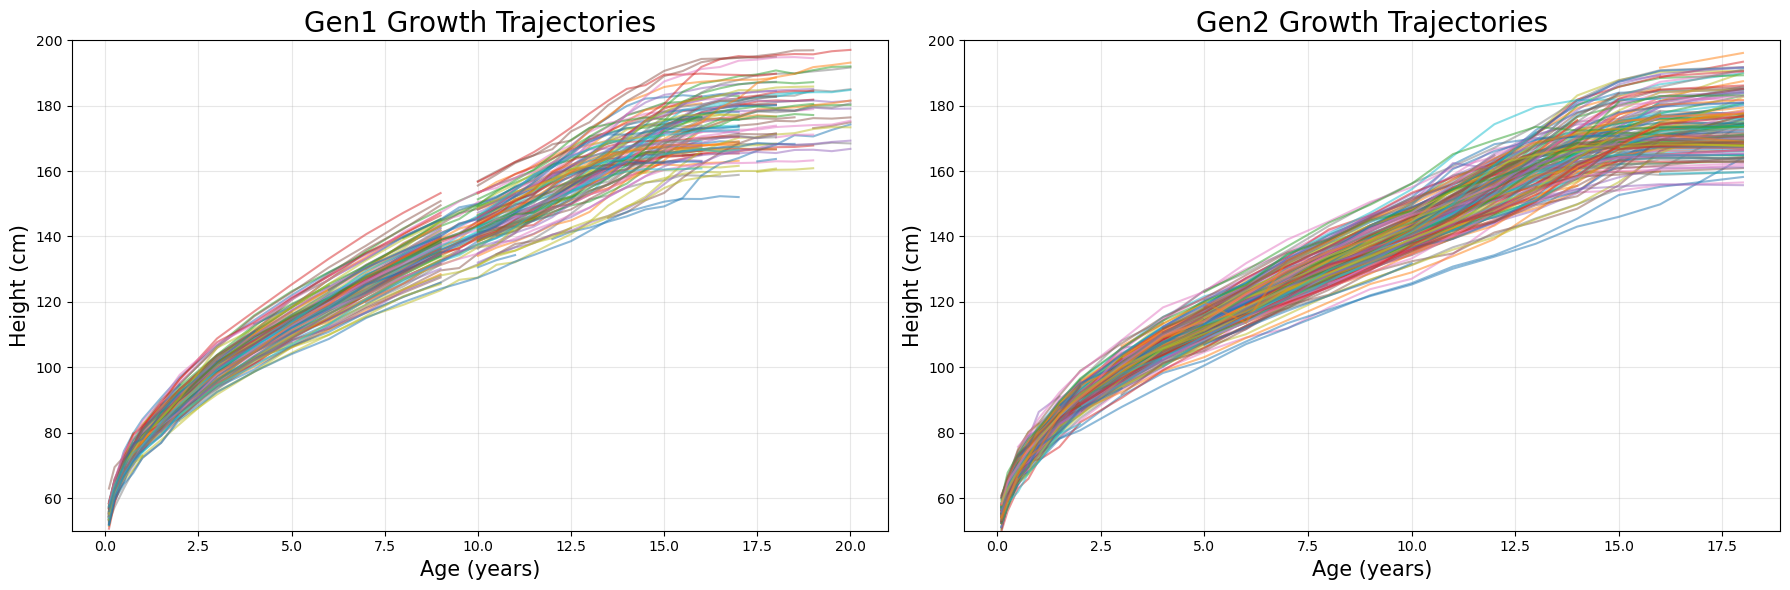

In [3]:
# Code to visualize individual growth trajectories for gen1 and gen2
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Sample 20 random individuals from both sexes
gen1_ids = gen1_train['gen1_id'].unique()
gen2_ids = gen2_train['gen2_id'].unique()

# Plot male growth trajectories
for gen1_id in gen1_ids:
    person_data = gen1_train[gen1_train['gen1_id'] == gen1_id]
    ax[0].plot(person_data['age'], person_data['SHgt_cm'], alpha=0.5, markersize=3)

# Plot female growth trajectories
for gen2_id in gen2_ids:
    person_data = gen2_train[gen2_train['gen2_id'] == gen2_id]
    ax[1].plot(person_data['AgeGr'], person_data['SHgt_cm'], alpha=0.5, markersize=3)

ax[0].set_title('Gen1 Growth Trajectories', fontsize=20)
ax[1].set_title('Gen2 Growth Trajectories', fontsize=20)

for i in range(2):
    ax[i].set_xlabel('Age (years)', fontsize=15)
    ax[i].set_ylabel('Height (cm)', fontsize=15)
    # ax[i].set_xlim(0, 18)
    ax[i].set_ylim(50, 200)
    ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


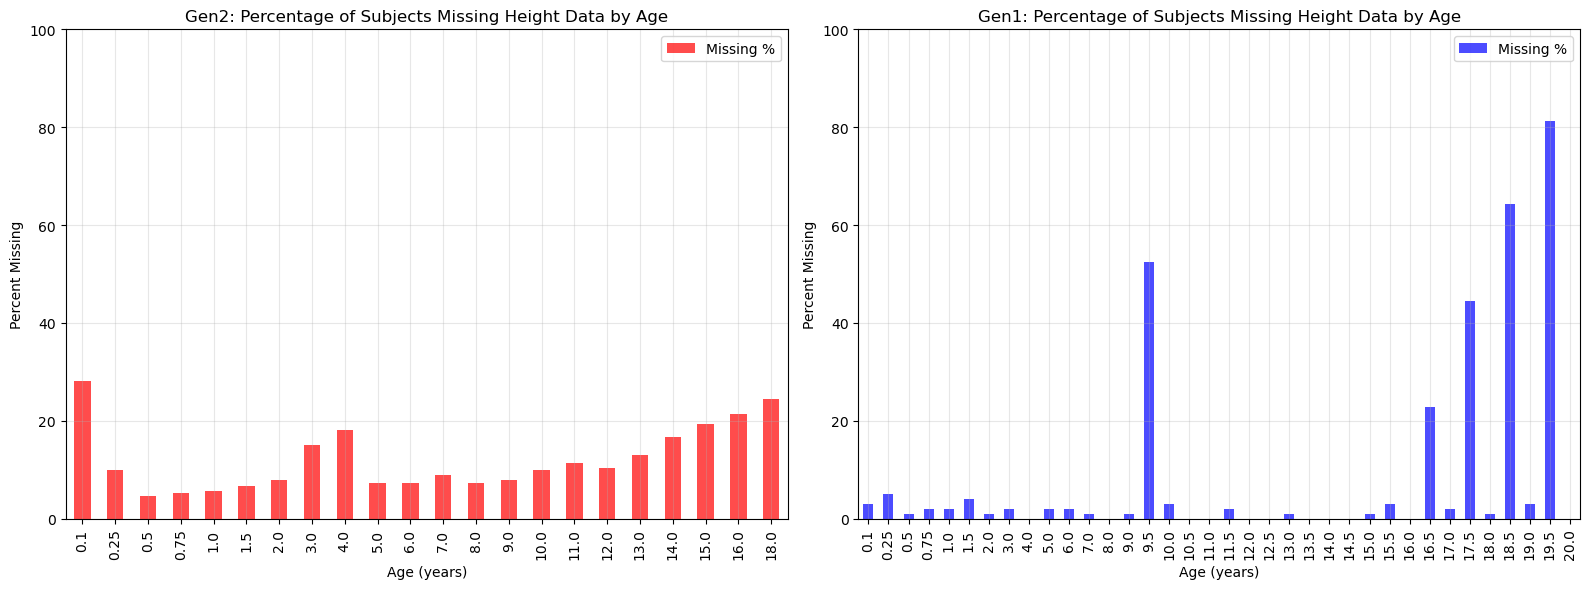

In [4]:
# Code for missingness analysis
def missing_data_analysis(gen2_train, gen1_train):
    # Get unique ages
    gen2_ages = sorted(gen2_train['AgeGr'].dropna().unique())
    gen1_ages = sorted(gen1_train['age'].dropna().unique())

    gen2_missing = []
    for age in gen2_ages:
        total_at_age = gen2_train[gen2_train['AgeGr'] == age]['gen2_id'].nunique()
        missing_at_age = gen2_train[(gen2_train['AgeGr'] == age) & (gen2_train['SHgt_cm'].isnull())]['gen2_id'].nunique()
        missing_pct = 100 * (missing_at_age / total_at_age) if total_at_age > 0 else 0
        gen2_missing.append({'Age': age, 'Missing %': missing_pct})

    gen1_missing = []
    for age in gen1_ages:
        total_at_age = gen1_train[gen1_train['age'] == age]['gen1_id'].nunique()
        missing_at_age = gen1_train[(gen1_train['age'] == age) & (gen1_train['SHgt_cm'].isnull())]['gen1_id'].nunique()
        missing_pct = 100 * (missing_at_age / total_at_age) if total_at_age > 0 else 0
        gen1_missing.append({'Age': age, 'Missing %': missing_pct})

    # Convert to DataFrame
    gen2_df = pd.DataFrame(gen2_missing)
    gen1_df = pd.DataFrame(gen1_missing)

    # Plot missing data by age
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    if not gen2_df.empty and gen2_df["Missing %"].sum() > 0:
        gen2_df.plot(x='Age', y='Missing %', kind='bar', ax=ax[0], color='red', alpha=0.7)
        ax[0].set_title('Gen2: Percentage of Subjects Missing Height Data by Age')
        ax[0].set_ylim(0, 100)

    if not gen1_df.empty and gen1_df["Missing %"].sum() > 0:
        gen1_df.plot(x='Age', y='Missing %', kind='bar', ax=ax[1], color='blue', alpha=0.7)
        ax[1].set_title('Gen1: Percentage of Subjects Missing Height Data by Age')
        ax[1].set_ylim(0, 100)

    for i in range(2):
        ax[i].set_xlabel('Age (years)')
        ax[i].set_ylabel('Percent Missing')
        ax[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call function
missing_data_analysis(gen2_train, gen1_train)


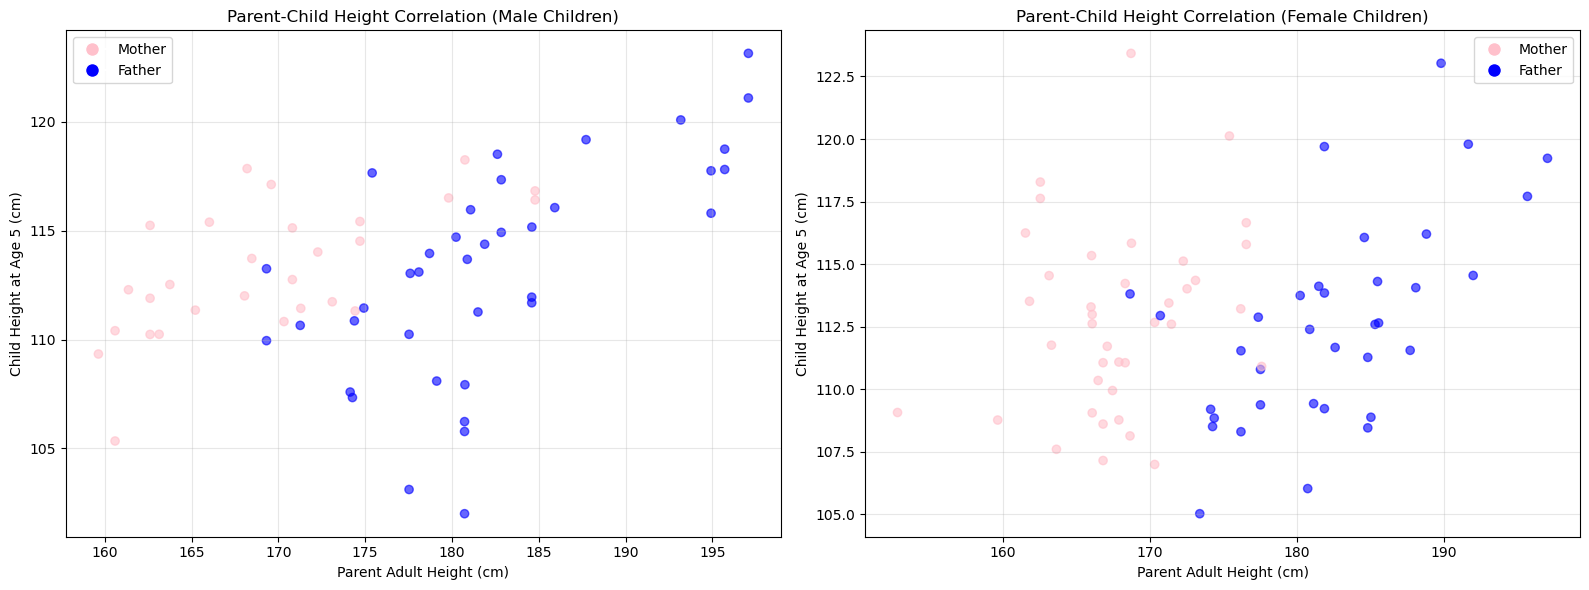

In [5]:
# Visualize parent-child height correlation
def plot_parent_child_correlation():
    # Create dataframe with parent and child data
    parent_heights = {}
    for parent_id in gen1_train['gen1_id'].unique():
        parent_data = gen1_train[gen1_train['gen1_id'] == parent_id]
        adult_height = parent_data[parent_data['age'] == 20]['SHgt_cm']
        if not adult_height.empty:
            parent_heights[parent_id] = adult_height.iloc[0]
    
    # Get early height data for children (e.g. at age 5)
    child_heights = {}
    for child_id in gen2_train['gen2_id'].unique():
        child_data = gen2_train[gen2_train['gen2_id'] == child_id]
        parent_id = child_data['study_parent_id_new'].iloc[0]
        height_5 = child_data[child_data['AgeGr'] == 5]['SHgt_cm']
        if not height_5.empty and parent_id in parent_heights:
            child_heights[child_id] = {
                'height_5': height_5.iloc[0],
                'parent_height': parent_heights[parent_id],
                'sex': child_data['sex_assigned_at_birth'].iloc[0],
                'parent_sex': child_data['study_parent_sex'].iloc[0]
            }
    
    # Convert to dataframe
    corr_df = pd.DataFrame.from_dict(child_heights, orient='index')
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Male children
    male_df = corr_df[corr_df['sex'] == 'M']
    ax[0].scatter(male_df['parent_height'], male_df['height_5'], 
                 alpha=0.6, c=male_df['parent_sex'].map({'mother': 'pink', 'father': 'blue'}))
    ax[0].set_title('Parent-Child Height Correlation (Male Children)')
    
    # Female children
    female_df = corr_df[corr_df['sex'] == 'F']
    ax[1].scatter(female_df['parent_height'], female_df['height_5'], 
                 alpha=0.6, c=female_df['parent_sex'].map({'mother': 'pink', 'father': 'blue'}))
    ax[1].set_title('Parent-Child Height Correlation (Female Children)')
    
    for i in range(2):
        ax[i].set_xlabel('Parent Adult Height (cm)')
        ax[i].set_ylabel('Child Height at Age 5 (cm)')
        ax[i].grid(True, alpha=0.3)
        
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=10, label='Mother'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Father')
    ]
    for i in range(2):
        ax[i].legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

plot_parent_child_correlation()


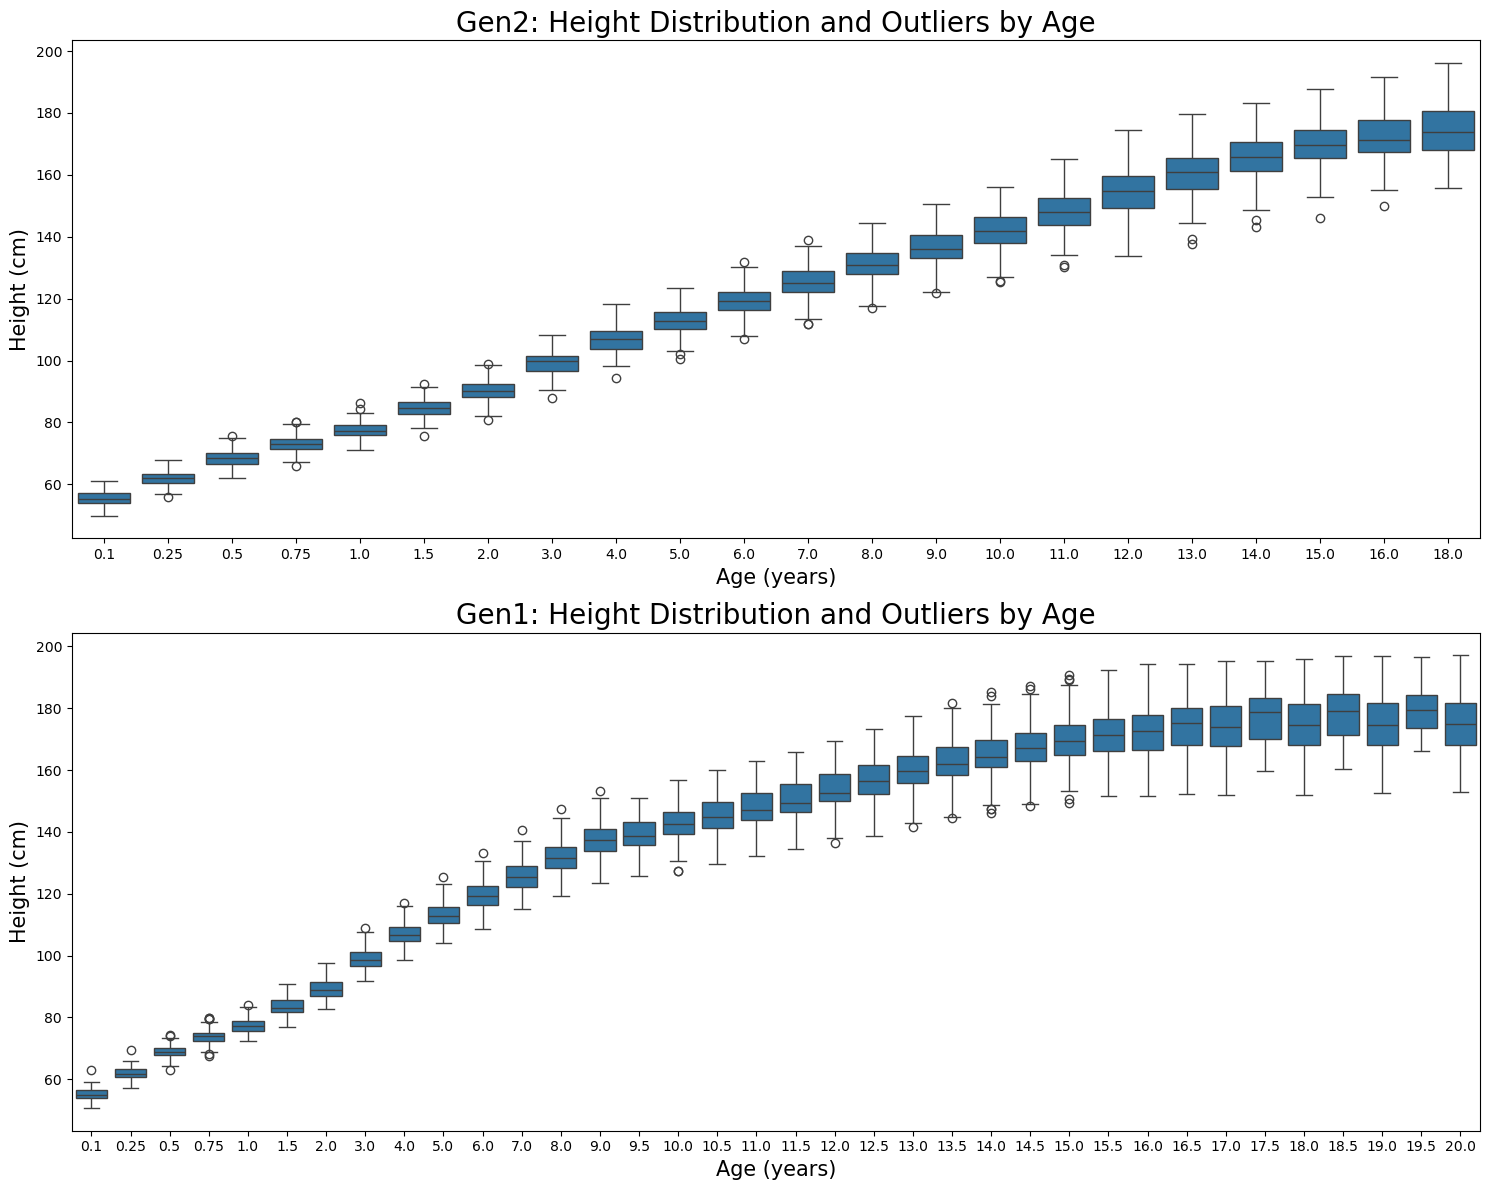

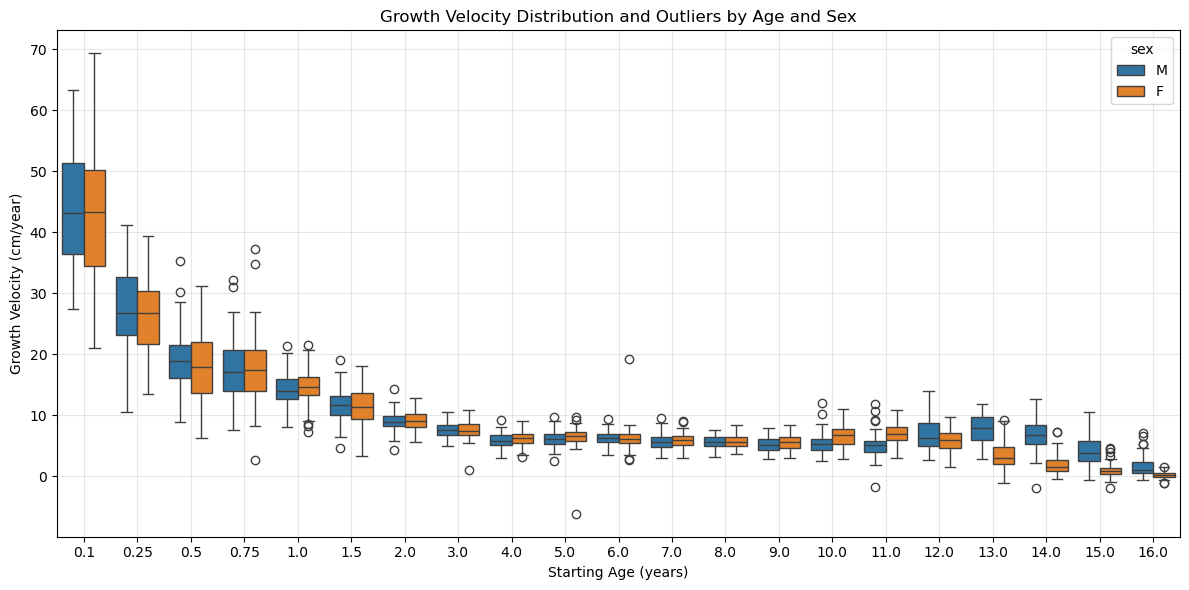

In [6]:
# Visualize height outliers using boxplots by age
def plot_height_outliers():
    # Create boxplots by age for both generations
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))
    
    # Gen2 outliers
    sns.boxplot(x='AgeGr', y='SHgt_cm', data=gen2_train, ax=ax[0])
    ax[0].set_title('Gen2: Height Distribution and Outliers by Age', fontsize=20)
    ax[0].set_xlabel('Age (years)', fontsize=15)
    ax[0].set_ylabel('Height (cm)', fontsize=15)
    
    # Gen1 outliers
    sns.boxplot(x='age', y='SHgt_cm', data=gen1_train, ax=ax[1])
    ax[1].set_title('Gen1: Height Distribution and Outliers by Age', fontsize=20)
    ax[1].set_xlabel('Age (years)', fontsize=15)
    ax[1].set_ylabel('Height (cm)', fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
    # Growth velocity outliers
    # Calculate growth velocities
    velocity_data = []
    
    for gen2_id in gen2_train['gen2_id'].unique():
        person_data = gen2_train[gen2_train['gen2_id'] == gen2_id].sort_values('AgeGr')
        if len(person_data) > 1:
            for i in range(len(person_data)-1):
                age1 = person_data.iloc[i]['AgeGr']
                age2 = person_data.iloc[i+1]['AgeGr']
                height1 = person_data.iloc[i]['SHgt_cm']
                height2 = person_data.iloc[i+1]['SHgt_cm']
                
                if pd.notna(height1) and pd.notna(height2):
                    velocity = (height2 - height1)/(age2 - age1)
                    velocity_data.append({
                        'gen2_id': gen2_id,
                        'start_age': age1,
                        'end_age': age2,
                        'velocity_cm_per_year': velocity,
                        'sex': person_data.iloc[i]['sex_assigned_at_birth']
                    })
    
    velocity_df = pd.DataFrame(velocity_data)
    
    # Plot velocity outliers
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='start_age', y='velocity_cm_per_year', hue='sex', data=velocity_df)
    plt.title('Growth Velocity Distribution and Outliers by Age and Sex')
    plt.xlabel('Starting Age (years)')
    plt.ylabel('Growth Velocity (cm/year)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_height_outliers()


# Data preparation and growth features implementation

In [7]:
def create_growth_features(df, gen1_data, is_training=True):
    """Create features for growth prediction"""
    features = []
    
    for gen2_id in df['gen2_id'].unique():
        # Get individual's data
        person_data = df[df['gen2_id'] == gen2_id]
        
        # Get parent's data
        parent_id = person_data['study_parent_id_new'].iloc[0]
        parent_data = gen1_data[gen1_data['gen1_id'] == parent_id]
        
        # Basic features
        feature_dict = {
            'gen2_id': gen2_id,
            'sex_assigned_at_birth': 1 if person_data['sex_assigned_at_birth'].iloc[0] == 'M' else 0,
            'parent_sex': 1 if person_data['study_parent_sex'].iloc[0] == 'father' else 0
        }
        
        # Early growth features (up to age 9)
        for age in [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]:
            height = person_data[person_data['AgeGr'] == age]['SHgt_cm'].iloc[0] if len(person_data[person_data['AgeGr'] == age]) > 0 else np.nan
            feature_dict[f'height_{age}'] = height
        
        # Growth velocities
        ages = sorted([0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9])
        for i in range(len(ages)-1):
            height1 = feature_dict[f'height_{ages[i]}']
            height2 = feature_dict[f'height_{ages[i+1]}']
            if pd.notna(height1) and pd.notna(height2):
                velocity = (height2 - height1)/(ages[i+1] - ages[i])
                feature_dict[f'velocity_{ages[i]}_{ages[i+1]}'] = velocity
            else:
                feature_dict[f'velocity_{ages[i]}_{ages[i+1]}'] = np.nan
        
        # Parent features
        if len(parent_data) > 0:
            feature_dict['parent_final_height'] = parent_data[parent_data['age'] == 20]['SHgt_cm'].iloc[0]
            
            # Parent's growth pattern
            for age in [5, 10, 15, 20]:
                height = parent_data[parent_data['age'] == age]['SHgt_cm'].iloc[0] if len(parent_data[parent_data['age'] == age]) > 0 else np.nan
                feature_dict[f'parent_height_{age}'] = height
        
        # Target variables (only for training data)
        if is_training:
            for age in [10, 11, 12, 13, 14, 15, 16, 18]:
                height = person_data[person_data['AgeGr'] == age]['SHgt_cm'].iloc[0] if len(person_data[person_data['AgeGr'] == age]) > 0 else np.nan
                feature_dict[f'target_{age}'] = height
        
        features.append(feature_dict)
    
    return pd.DataFrame(features)

# Prepare training and testing data
train_features = create_growth_features(gen2_train, gen1_train, is_training=True)
test_features = create_growth_features(gen2_test, gen1_test, is_training=False)


## Dealing with outliers

In [8]:
def clip_outliers_iqr(df, age_columns):
    """
    Clips outliers in the specified age columns of the dataframe using the IQR method.

    Parameters:
    df (pd.DataFrame): The input dataframe containing age columns.
    age_columns (list): List of column names corresponding to different ages.

    Returns:
    pd.DataFrame: DataFrame with outliers in specified columns clipped to the IQR bounds.
    """
    df_clipped = df.copy()

    for col in age_columns:
        # Drop NaN values for the current age column
        data = df[col].dropna()

        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1

        # Determine the outlier criteria
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Clip the outliers to the lower and upper bounds
        df_clipped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

        # Optional: Print the clipping information
        print(f"Age {col}:")
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        print(f"Number of values clipped: {(df[col] < lower_bound).sum() + (df[col] > upper_bound).sum()}")
        print("\n")

    return df_clipped

age_columns = [f'target_{age}' for age in [10, 11, 12, 13, 14, 15, 16, 18]]
train_features = clip_outliers_iqr(train_features, age_columns)


Age target_10:
Lower bound: 125.89100599999998, Upper bound: 158.46938760000003
Number of values clipped: 2


Age target_11:
Lower bound: 131.06618839999996, Upper bound: 165.19776280000005
Number of values clipped: 2


Age target_12:
Lower bound: 133.46735886250005, Upper bound: 175.26808796249995
Number of values clipped: 0


Age target_13:
Lower bound: 140.33703797500002, Upper bound: 180.39759897500002
Number of values clipped: 2


Age target_14:
Lower bound: 147.189322, Upper bound: 184.52495019999998
Number of values clipped: 2


Age target_15:
Lower bound: 151.503842975, Upper bound: 188.35213197500002
Number of values clipped: 1


Age target_16:
Lower bound: 152.16185910000002, Upper bound: 193.08628109999995
Number of values clipped: 1


Age target_18:
Lower bound: 148.92506514999997, Upper bound: 199.54105035000003
Number of values clipped: 0




# Implementation
##  1. Preece-Baines Growth Model
 
## The Preece-Baines model is a mathematical model used to describe human growth.
## Estimates growth during adolescence and can estimate adult height based on growth measurements from different ages.

In [9]:
# Define Preece-Baines model function
def preece_baines(t, h1, h_theta, a, b, c):
    """
    Preece-Baines growth model function.
    
    Parameters:
    -----------
    t : float or array
        Age in years
    h1 : float
        Estimated adult height
    h_theta : float
        Height at the inflection point
    a : float
        Growth rate parameter
    b : float
        Growth rate parameter
    c : float
        Age at peak velocity
        
    Returns:
    --------
    float or array
        Height at age t
    """
    denominator = np.exp(a * (t - c)) + np.exp(b * (t - c))
    return h1 - 2 * (h1 - h_theta) / denominator

# %%
def fit_preece_baines(row, height_cols):
    """
    Fit Preece-Baines model to an individual's height data.
    
    Parameters:
    -----------
    row : Series
        A row from the DataFrame containing height measurements
    height_cols : list
        List of column names containing height measurements at different ages
        
    Returns:
    --------
    dict
        Dictionary with Preece-Baines parameters and height predictions for target ages
    """
    # Extract age and height pairs
    ages, heights = [], []
    
    # Get heights from height columns
    for col in height_cols:
        if col in row.index and not pd.isna(row[col]):
            age = float(col.split('_')[1])  # Extract age from column name
            heights.append(row[col])
            ages.append(age)
    
    # Need at least 5 data points for a reasonable fit
    if len(ages) < 5:
        return {}
    
    # Sort by age
    sorted_indices = np.argsort(ages)
    ages_sorted = np.array(ages)[sorted_indices]
    heights_sorted = np.array(heights)[sorted_indices]
    
    # Initial parameter estimates based on data and domain knowledge
    try:
        # Use parent height as a reference if available
        if 'parent_final_height' in row and not pd.isna(row['parent_final_height']):
            h1_initial = row['parent_final_height']
        else:
            # Otherwise make an educated guess based on latest measurement
            h1_initial = heights_sorted[-1] + 10 if heights_sorted[-1] < 170 else heights_sorted[-1]
        
        h_theta_initial = heights_sorted[-1] * 0.9  # Height at inflection point
        
        # Age constants based on typical growth patterns
        if row['sex_assigned_at_birth'] == 1:  # Male
            c_initial = 14  # Boys typically hit peak velocity around age 14
        else:  # Female
            c_initial = 12  # Girls typically hit peak velocity around age 12
        
        a_initial, b_initial = 0.5, 0.5  # Starting values for rate constants
        
        # Set bounds for the parameters
        bounds = (
            [h_theta_initial - 20, h_theta_initial - 20, 0.001, 0.001, 8],  # Lower bounds
            [h1_initial + 20, h1_initial + 20, 5, 5, 18]  # Upper bounds
        )
        
        # Fit the model with curve_fit
        params, _ = curve_fit(
            preece_baines,
            ages_sorted,
            heights_sorted,
            p0=[h1_initial, h_theta_initial, a_initial, b_initial, c_initial],
            bounds=bounds,
            maxfev=15000
        )
        
        # Extract fitted parameters
        h1, h_theta, a, b, c = params
        
        # Generate predictions for target ages
        results = {
            'pb_h1': h1,           # Estimated adult height
            'pb_h_theta': h_theta, # Height at inflection
            'pb_a': a,             # Growth rate parameter a
            'pb_b': b,             # Growth rate parameter b
            'pb_c': c              # Age at peak velocity
        }
        
        # Predict heights at specific target ages
        for age in [10, 11, 12, 13, 14, 15, 16, 18]:
            results[f'pb_pred_{age}'] = preece_baines(age, h1, h_theta, a, b, c)
        
        return results
    
    except Exception as e:
        # Return empty dictionary if fitting fails
        print(f"Fitting failed: {e}")
        return {}

def add_preece_baines_features(df, height_cols):
    """
    Add Preece-Baines model parameters and predictions as features to the DataFrame.
    
    Parameters:
    df: DataFrame containing height measurements
    height_cols: List of columns containing height measurements
    
    Returns:
    DataFrame with added Preece-Baines features
    """
    print("Fitting Preece-Baines models...")
    
    # Apply the fitting function to each row
    pb_results = df.apply(lambda row: fit_preece_baines(row, height_cols), axis=1)
    
    # Initialize new columns with NaN
    pb_params = ['pb_h1', 'pb_h_theta', 'pb_a', 'pb_b', 'pb_c']
    for param in pb_params:
        df[param] = np.nan
    
    for age in [10, 11, 12, 13, 14, 15, 16, 18]:
        df[f'pb_pred_{age}'] = np.nan
    
    # Fill in values from successful fits
    for idx, result in pb_results.items():
        if result:  # If fitting was successful
            for key, value in result.items():
                df.loc[idx, key] = value
    
    # Count how many rows had successful fits
    success_count = sum(1 for result in pb_results if result)
    print(f"Successfully fitted Preece-Baines model to {success_count} out of {len(df)} rows ({success_count/len(df)*100:.1f}%)")
    
    # Impute missing Preece-Baines parameters and predictions
    pb_columns = pb_params + [f'pb_pred_{age}' for age in [10, 11, 12, 13, 14, 15, 16, 18]]
    missing_before = df[pb_columns].isna().sum().sum()
    if missing_before > 0:
        print(f"Imputing {missing_before} missing Preece-Baines values...")
        
        # Group by sex for more accurate imputation
        for sex in df['sex_assigned_at_birth'].unique():
            mask = df['sex_assigned_at_birth'] == sex
            if mask.sum() > 1:  # Need at least 2 samples for imputation
                # For each sex group, impute missing values
                imputer = KNNImputer(n_neighbors=min(3, mask.sum()-1))
                df.loc[mask, pb_columns] = imputer.fit_transform(df.loc[mask, pb_columns])
    
    missing_after = df[pb_columns].isna().sum().sum()
    print(f"Missing Preece-Baines values after imputation: {missing_after}")
    
    return df


def prepare_data(train_features, test_features):
    """
Prepare the data for modeling by imputing missing values,
adding Preece-Baines features, and preparing categorical features.
"""
    print("Starting data preparation...")

    # Create copies to avoid modifying the originals
    train_df = train_features.copy()
    test_df = test_features.copy()

    # Check input data
    print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

    # Define columns by type
    categorical_cols = ['sex_assigned_at_birth', 'parent_sex']
    target_cols = [col for col in train_df.columns if col.startswith('target_')]
    id_col = 'gen2_id'

    # Get all numerical columns excluding categorical, target and ID columns
    all_num_cols = [col for col in train_df.columns 
                    if train_df[col].dtype in ['float64', 'int64'] 
                    and col not in categorical_cols 
                    and not col.startswith('target_')
                    and col != id_col]

    # Identify feature groups
    height_cols = [col for col in all_num_cols if col.startswith('height_')]
    parent_height_cols = [col for col in all_num_cols if col.startswith('parent_height_')]
    velocity_cols = [col for col in all_num_cols if col.startswith('velocity_')]
    other_num_cols = [col for col in all_num_cols 
                        if col not in height_cols + parent_height_cols + velocity_cols 
                        and col != 'parent_final_height']

    # Report column counts
    print(f"Number of height measurements: {len(height_cols)}")
    print(f"Number of parent height measurements: {len(parent_height_cols)}")
    print(f"Number of velocity measurements: {len(velocity_cols)}")

    # Apply KNN Imputation to all numerical columns
    print("Imputing missing values...")
    imputer = KNNImputer(n_neighbors=3)
    train_df[all_num_cols] = imputer.fit_transform(train_df[all_num_cols])
    test_df[all_num_cols] = imputer.transform(test_df[all_num_cols])

    # Add Preece-Baines features
    train_df = add_preece_baines_features(train_df, height_cols)
    test_df = add_preece_baines_features(test_df, height_cols)

    # Convert categorical columns to the right type for CatBoost
    for col in categorical_cols:
        train_df[col] = train_df[col].astype(int)
        test_df[col] = test_df[col].astype(int)

    return train_df, test_df, categorical_cols, target_cols


## 2. CatBoost Model Tuning
###  Here we implement hyperparameter tuning for CatBoost using RandomizedSearchCV.


In [10]:

def tune_with_randomized_search(X_train, y_train, categorical_cols, n_iter=50, cv=5):
    """
    Tune CatBoost hyperparameters using RandomizedSearchCV.
    
    Parameters:
    -----------
    X_train : DataFrame
        Training features
    y_train : Series
        Target values
    categorical_cols : list
        List of categorical column names
    n_iter : int, default=20
        Number of parameter settings sampled
    cv : int, default=5
        Number of cross-validation folds
        
    Returns:
    --------
    dict
        Best parameters found
    """
    print(f"Tuning hyperparameters with RandomizedSearchCV (n_iter={n_iter}, cv={cv})...")
    
    # Create parameter distribution for randomized search
    param_dist = {
        'iterations': [1000, 2000, 3000],
        'learning_rate': uniform(0.005, 0.095), 
        'depth': randint(3, 8),  
        'l2_leaf_reg': uniform(1, 14),  
        'random_strength': uniform(0.5, 2.5),  
        'bagging_temperature': uniform(0.5, 1.5),  
        'subsample': uniform(0.6, 0.3),  
        'rsm': uniform(0.6, 0.3)  # 0.6 to 0.9 
    }
    
    # Create base model
    base_model = CatBoostRegressor(
        loss_function='RMSE',
        random_seed=42,
        cat_features=categorical_cols,
        verbose=0, 
        od_type='Iter'
    )
    
    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        random_state=42,
        n_jobs=-1,  # Use all available cores
        verbose=2
    )
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    # Print results
    print(f"\nBest parameters: {random_search.best_params_}")
    print(f"Best RMSE: {-random_search.best_score_:.4f}")
    
    return random_search.best_params_



##  3. Building CatBoost Models with Hyperparameter Tuning
### This function builds and evaluates CatBoost models for each target age, with optional validation and hyperparameter tuning.


In [11]:
def build_catboost_models_with_tuning(train_df, test_df, categorical_cols, target_cols, validation=True):
    """
    Enhanced build_catboost_models function that uses RandomizedSearchCV for tuning.
    """
    print("Building CatBoost models with hyperparameter tuning...")
    
    # Create results DataFrames
    predictions_train = pd.DataFrame({'gen2_id': train_df['gen2_id']})
    predictions_test = pd.DataFrame({'gen2_id': test_df['gen2_id']})
    
    # Save validation metrics
    validation_metrics = {}
    
    # Create feature list (all columns except targets and gen2_id)
    feature_cols = [col for col in train_df.columns 
                    if not col.startswith('target_') and col != 'gen2_id']
    
    if validation:
        # Split for validation
        train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=42)
        print(f"Training set size: {train_set.shape[0]}, Validation set size: {val_set.shape[0]}")
    else:
        # Use all training data
        train_set = train_df
        print(f"Using full training set: {train_set.shape[0]} rows")
    
    # Store best parameters for each target age
    best_params_by_age = {}
    
    # Build a model for each target age
    for target_col in target_cols:
        age = int(target_col.split('_')[1])  # Extract age from column name
        print(f"\nTraining model for {target_col}...")
        
        # Skip if there's no data for this target
        if train_df[target_col].notna().sum() == 0:
            print(f"No training data for {target_col}, using Preece-Baines predictions only...")
            # Use Preece-Baines predictions directly
            predictions_train[target_col] = train_df[f'pb_pred_{age}']
            predictions_test[target_col] = test_df[f'pb_pred_{age}']
            continue
        
        # Get training data for this target (only use rows with non-null target values)
        mask = train_set[target_col].notna()
        X_train = train_set.loc[mask, feature_cols]
        y_train = train_set.loc[mask, target_col]
        
        print(f"Training on {len(y_train)} samples for {target_col}")
        
        # Tune hyperparameters if we have enough data (>100 samples)
        if len(y_train) > 100:
            # Use fewer iterations for faster tuning
            n_iter = min(20, max(10, len(y_train) // 50))
            cv_folds = min(5, max(3, len(y_train) // 100))
            
            print(f"Tuning hyperparameters with {n_iter} iterations and {cv_folds}-fold CV...")
            best_params = tune_with_randomized_search(
                X_train, y_train, categorical_cols, n_iter=n_iter, cv=cv_folds
            )
            
            # Store best parameters for reference
            best_params_by_age[age] = best_params
            
            # Create model with best parameters
            model = CatBoostRegressor(
                **best_params,
                random_seed=42,
                cat_features=categorical_cols,
                verbose=100,
                od_type='Iter'
            )
        else:
            print("Not enough data for tuning, using default regularized model...")
            # Use default regularized model
            model = CatBoostRegressor(
                iterations=3000,
                learning_rate=0.01,
                depth=6,
                l2_leaf_reg=10,
                loss_function='RMSE',
                random_seed=42,
                cat_features=categorical_cols,
                verbose=100,
                random_strength=1.5,
                bagging_temperature=1.2,
                subsample=0.75,
                rsm=0.8,
                early_stopping_rounds=100,
                od_type='Iter'
            )
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Store feature importances
        feature_importance = model.get_feature_importance()
        importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        print(f"\nTop 10 features for {target_col}:")
        print(importance_df.head(10))
        
        # Evaluate on validation set if requested
        if validation:
            # Get validation data
            X_val = val_set[feature_cols]
            y_val = val_set[target_col].dropna()
            mask_val = val_set[target_col].notna()
            X_val_filtered = X_val.loc[mask_val]
            
            # Make predictions on validation set
            val_preds = model.predict(X_val_filtered)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_val, val_preds))
            validation_metrics[target_col] = rmse
            print(f"Validation RMSE for {target_col}: {rmse:.2f}")
            
            # Also calculate RMSE for Preece-Baines only
            pb_preds = val_set.loc[mask_val, f'pb_pred_{age}']
            pb_rmse = np.sqrt(mean_squared_error(y_val, pb_preds))
            print(f"Preece-Baines only RMSE for {target_col}: {pb_rmse:.2f}")
            
            # Compare with combined approach (50% CatBoost, 50% Preece-Baines)
            combined_preds = 0.5 * val_preds + 0.5 * pb_preds
            combined_rmse = np.sqrt(mean_squared_error(y_val, combined_preds))
            print(f"Combined approach RMSE for {target_col}: {combined_rmse:.2f}")
            
            # Use the better approach for final predictions
            if combined_rmse < rmse and combined_rmse < pb_rmse:
                print(f"Using combined approach for {target_col}")
                val_preds = combined_preds
            elif pb_rmse < rmse:
                print(f"Using Preece-Baines only for {target_col}")
                val_preds = pb_preds
            else:
                print(f"Using CatBoost only for {target_col}")
            
            # Add validation predictions to training predictions
            val_pred_series = pd.Series(index=val_set.loc[mask_val].index, data=val_preds)
            predictions_train.loc[val_pred_series.index, target_col] = val_pred_series
        
        # Predict on test set
        test_preds = model.predict(test_df[feature_cols])
        pb_test_preds = test_df[f'pb_pred_{age}']
        
        # Use the best approach based on validation
        if validation and 'combined_rmse' in locals():
            if combined_rmse < rmse and combined_rmse < pb_rmse:
                # Combined approach
                predictions_test[target_col] = 0.5 * test_preds + 0.5 * pb_test_preds
            elif pb_rmse < rmse:
                # Preece-Baines only
                predictions_test[target_col] = pb_test_preds
            else:
                # CatBoost only
                predictions_test[target_col] = test_preds
        else:
            # Default to CatBoost
            predictions_test[target_col] = test_preds
    
    if validation:
        print("\nValidation metrics summary:")
        for col, rmse in validation_metrics.items():
            print(f"{col}: RMSE = {rmse:.2f}")
    
    # Save best parameters to file for reference
    if best_params_by_age:
        with open('best_hyperparameters.txt', 'w') as f:
            for age, params in best_params_by_age.items():
                f.write(f"Age {age}:\n")
                for param, value in params.items():
                    f.write(f"  {param}: {value}\n")
                f.write("\n")
        print("Best hyperparameters saved to 'best_hyperparameters.txt'")
    
    return predictions_train, predictions_test

train_df, test_df, categorical_cols, target_cols = prepare_data(train_features, test_features)

predictions_train, predictions_test = build_catboost_models_with_tuning(
train_df, test_df, categorical_cols, target_cols, validation=True
    )


Starting data preparation...
Train shape: (192, 43), Test shape: (88, 35)
Number of height measurements: 14
Number of parent height measurements: 4
Number of velocity measurements: 13
Imputing missing values...
Fitting Preece-Baines models...
Successfully fitted Preece-Baines model to 192 out of 192 rows (100.0%)
Missing Preece-Baines values after imputation: 0
Fitting Preece-Baines models...
Successfully fitted Preece-Baines model to 88 out of 88 rows (100.0%)
Missing Preece-Baines values after imputation: 0
Building CatBoost models with hyperparameter tuning...
Training set size: 153, Validation set size: 39

Training model for target_10...
Training on 136 samples for target_10
Tuning hyperparameters with 10 iterations and 3-fold CV...
Tuning hyperparameters with RandomizedSearchCV (n_iter=10, cv=3)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bagging_temperature=0.7751067647801507, depth=6, iterations=2000, l2_leaf_reg=8.346590042851329, learning_rate=0.0

## Analysis

In [12]:
# Question 2: Growth Spurt Analysis and Hereditary Patterns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

def calculate_growth_spurt_metrics(df, gen1_data):
    """
    Calculate growth spurt metrics for each individual in the dataset.
    Returns DataFrame with growth spurt metrics including velocities, onset/end times, and durations.
    """
    print("Calculating growth spurt metrics...")
    results = []
    
    for gen2_id in df['gen2_id'].unique():
        person_data = df[df['gen2_id'] == gen2_id]
        sex = person_data['sex_assigned_at_birth'].iloc[0]
        parent_sex = person_data['parent_sex'].iloc[0] if 'parent_sex' in person_data.columns else None
        
        metrics = {
            'gen2_id': gen2_id,
            'sex': sex,
            'parent_sex': parent_sex
        }
        
        heights = {}
        for age_col in [col for col in person_data.columns if col.startswith('height_')]:
            age = float(age_col.split('_')[1])
            if not pd.isna(person_data[age_col].iloc[0]):
                heights[age] = person_data[age_col].iloc[0]
        
        available_ages = sorted(heights.keys())
        if len(available_ages) >= 2:
            metrics['height_gain_total'] = heights[available_ages[-1]] - heights[available_ages[0]]
            metrics['height_gain_period'] = f"{available_ages[0]}-{available_ages[-1]}"
            
            velocities = []
            for i in range(len(available_ages)-1):
                age1 = available_ages[i]
                age2 = available_ages[i+1]
                velocity = (heights[age2] - heights[age1]) / (age2 - age1)
                metrics[f'velocity_{age1}_{age2}'] = velocity
                velocities.append(velocity)
            
            if velocities:
                metrics['peak_velocity'] = max(velocities)
                metrics['avg_velocity'] = sum(velocities) / len(velocities)
        
        pb_cols = ['pb_h1', 'pb_h_theta', 'pb_a', 'pb_b', 'pb_c']
        for col in pb_cols:
            if col in person_data.columns:
                pb_value = person_data[col].dropna().iloc[0] if not person_data[col].dropna().empty else np.nan
                metrics[col] = pb_value
        
        parent_height_cols = [col for col in person_data.columns if col.startswith('parent_height_')]
        for col in parent_height_cols:
            if not pd.isna(person_data[col].iloc[0]):
                metrics[col] = person_data[col].iloc[0]
        
        if 'parent_final_height' in person_data.columns and not pd.isna(person_data['parent_final_height'].iloc[0]):
            metrics['parent_final_height'] = person_data['parent_final_height'].iloc[0]
        
        parent_heights = {}
        for col in parent_height_cols:
            age = float(col.split('_')[-1])
            if not pd.isna(person_data[col].iloc[0]):
                parent_heights[age] = person_data[col].iloc[0]
        
        parent_ages = sorted(parent_heights.keys())
        for i in range(len(parent_ages)-1):
            age1 = parent_ages[i]
            age2 = parent_ages[i+1]
            parent_velocity = (parent_heights[age2] - parent_heights[age1]) / (age2 - age1)
            metrics[f'parent_velocity_{age1}_{age2}'] = parent_velocity
        
        results.append(metrics)
    
    results_df = pd.DataFrame(results)
    
    if 'pb_c' in results_df.columns:
        results_df['age_at_peak_velocity'] = results_df['pb_c']
    
    velocity_cols = [col for col in results_df.columns if col.startswith('velocity_') and not col.startswith('parent_')]
    if velocity_cols:
        threshold = 6
        
        for idx, row in results_df.iterrows():
            velocities = []
            for col in velocity_cols:
                if pd.notna(row[col]):
                    parts = col.split('_')
                    if len(parts) >= 3:
                        try:
                            age1 = float(parts[1])
                            age2 = float(parts[2])
                            mid_age = (age1 + age2) / 2
                            velocities.append((mid_age, row[col]))
                        except ValueError:
                            continue
            
            velocities.sort(key=lambda x: x[0])
            
            if velocities:
                onset_ages = [age for age, vel in velocities if vel >= threshold]
                if onset_ages:
                    results_df.loc[idx, 'growth_spurt_onset'] = min(onset_ages)
                
                if 'peak_velocity' in row and pd.notna(row['peak_velocity']):
                    peak_vel = row['peak_velocity']
                    peak_ages = [age for age, vel in velocities if vel == peak_vel]
                    if peak_ages:
                        peak_age = min(peak_ages)
                        post_peak = [(age, vel) for age, vel in velocities if age > peak_age]
                        end_ages = [age for age, vel in post_peak if vel < threshold]
                        if end_ages:
                            results_df.loc[idx, 'growth_spurt_end'] = min(end_ages)
                
                if pd.notna(results_df.loc[idx, 'growth_spurt_onset']) and pd.notna(results_df.loc[idx, 'growth_spurt_end']):
                    results_df.loc[idx, 'growth_spurt_duration'] = results_df.loc[idx, 'growth_spurt_end'] - results_df.loc[idx, 'growth_spurt_onset']
    
    print(f"Calculated growth spurt metrics for {len(results_df)} individuals")
    return results_df


In [13]:
def analyze_parent_child_correlations(metrics_df, metric_type='magnitude'):
    """
    Analyze correlations between parent and child growth metrics.
    Returns DataFrame with correlation results.
    """
    if metric_type == 'magnitude':
        child_metrics = ['height_gain_total', 'peak_velocity', 'avg_velocity']
        parent_metrics = ['parent_final_height', 'parent_height_15', 'parent_height_20']
    else:
        child_metrics = ['growth_spurt_onset', 'growth_spurt_end', 'growth_spurt_duration']
        parent_metrics = ['parent_velocity_5.0_10.0', 'parent_velocity_10.0_15.0', 'parent_velocity_15.0_20.0']

    correlation_results = []

    for child_metric in child_metrics:
        if child_metric not in metrics_df.columns:
            continue
            
        for parent_metric in parent_metrics:
            if parent_metric not in metrics_df.columns:
                continue
                
            valid_data = metrics_df[[child_metric, parent_metric]].dropna()
            
            if len(valid_data) < 10:
                continue
                
            pearson_r, pearson_p = stats.pearsonr(valid_data[child_metric], valid_data[parent_metric])
            spearman_r, spearman_p = stats.spearmanr(valid_data[child_metric], valid_data[parent_metric])
            
            correlation_results.append({
                'child_metric': child_metric,
                'parent_metric': parent_metric,
                'n_samples': len(valid_data),
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'spearman_r': spearman_r,
                'spearman_p': spearman_p
            })
    
    results_df = pd.DataFrame(correlation_results)
    
    if not results_df.empty:
        multipletests_result = multipletests(results_df['pearson_p'], method='fdr_bh')
        results_df['pearson_p_adjusted'] = multipletests_result[1]
        
        multipletests_result = multipletests(results_df['spearman_p'], method='fdr_bh')
        results_df['spearman_p_adjusted'] = multipletests_result[1]
        
        results_df = results_df.sort_values('pearson_r', ascending=False)
    else:
        results_df = pd.DataFrame(columns=[
            'child_metric', 'parent_metric', 'n_samples', 
            'pearson_r', 'pearson_p', 'spearman_r', 'spearman_p',
            'pearson_p_adjusted', 'spearman_p_adjusted'
        ])

    return results_df


In [14]:
def build_predictive_models(metrics_df, target_metric, parent_features, model_type='catboost'):
    # Validate inputs and prepare data
    if target_metric not in metrics_df.columns:
        print(f"Target metric {target_metric} not found in data")
        return None
    
    valid_features = [f for f in parent_features if f in metrics_df.columns]
    if not valid_features:
        print("No valid parent features found")
        return None
    
    data = metrics_df[[target_metric] + valid_features].copy()
    data = data.dropna(subset=[target_metric])
    data = data.dropna(thresh=2)  # Require target + at least one feature
    
    if len(data) < 10:
        print(f"Not enough data (n={len(data)})")
        return None
    
    target_std = data[target_metric].std()
    if target_std < 0.001:
        print(f"Target {target_metric} has very low variance, skipping")
        return None
    
    for col in valid_features:
        if data[col].isna().any():
            data[col] = data[col].fillna(data[col].mean())
    
    X = data[valid_features]
    y = data[target_metric]
    
    if y.nunique() <= 1:
        print(f"Target {target_metric} has only {y.nunique()} unique values")
        return None
    
    # Split data if enough samples
    if len(data) >= 20:
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        has_test_set = True
    else:
        X_train, y_train = X, y
        X_test, y_test = None, None
        has_test_set = False
    
    try:
        from catboost import CatBoostRegressor
        model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, verbose=0)
        
        model.fit(X_train, y_train)
        
        # Calculate training metrics
        train_preds = model.predict(X_train)
        train_r2 = r2_score(y_train, train_preds)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        
        if train_r2 < -2.0:
            train_r2 = -2.0
        
        # Get feature importance
        importances = {feature: imp for feature, imp in zip(valid_features, model.feature_importances_)}
        importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=True)}
        
        results = {
            'target_metric': target_metric,
            'model_type': 'catboost',
            'n_samples': len(data),
            'features': valid_features,
            'train_r2': train_r2,
            'train_rmse': train_rmse,
            'feature_importances': importances
        }
        
        # Add test metrics if available
        if has_test_set:
            test_preds = model.predict(X_test)
            test_r2 = r2_score(y_test, test_preds)
            
            if test_r2 < -2.0:
                test_r2 = -2.0
                
            test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
            results['test_r2'] = test_r2
            results['test_rmse'] = test_rmse
            
        return results
    
    except Exception as e:
        print(f"Error building model for {target_metric}: {str(e)}")
        return None


In [15]:
def analyze_sex_differences(metrics_df, metric_type):
    """Analyze differences in heredity patterns based on sex combinations."""
    print(f"Analyzing sex-based differences in heredity for {metric_type} metrics...")
    
    if metrics_df.empty:
        return pd.DataFrame(columns=['sex_combo', 'metric', 'correlation', 'p_value', 'sample_size'])

    metrics_df['sex_combo'] = metrics_df.apply(
        lambda row: f"{'M' if row['parent_sex'] == 0 else 'F'}/{'M' if row['sex'] == 1 else 'F'}", 
        axis=1
    )
    
    sex_combos = ['M/M', 'M/F', 'F/M', 'F/F']
    combo_counts = metrics_df['sex_combo'].value_counts().to_dict()
    
    print("\nSex combination counts:")
    for combo in sex_combos:
        count = combo_counts.get(combo, 0)
        print(f"{combo}: {count} individuals")

    results = {'combo_counts': combo_counts}
    model_results_by_combo = {}
    
    for combo in sex_combos:
        combo_data = metrics_df[metrics_df['sex_combo'] == combo]
        
        if len(combo_data) < 10:
            print(f"Not enough data for {combo} combination (n={len(combo_data)})")
            continue
            
        print(f"Analyzing {combo} combination (n={len(combo_data)})")
        
        corr_results = analyze_parent_child_correlations(combo_data, metric_type)
        model_results = {}
        parent_features = [col for col in combo_data.columns if col.startswith('parent_') and not col.endswith('sex')]
        
        if metric_type == 'magnitude':
            if 'height_gain_total' in combo_data.columns:
                model_results['height_gain'] = build_predictive_models(
                    combo_data, 'height_gain_total', parent_features, 'random_forest'
                )
            
            if 'peak_velocity' in combo_data.columns:
                model_results['peak_velocity'] = build_predictive_models(
                    combo_data, 'peak_velocity', parent_features, 'random_forest'
                )
        else:
            if 'growth_spurt_onset' in combo_data.columns:
                onset_std = combo_data['growth_spurt_onset'].std()
                if onset_std >= 0.001:
                    model_results['growth_spurt_onset'] = build_predictive_models(
                        combo_data, 'growth_spurt_onset', parent_features, 'random_forest'
                    )
            
            if 'growth_spurt_duration' in combo_data.columns:
                model_results['growth_spurt_duration'] = build_predictive_models(
                    combo_data, 'growth_spurt_duration', parent_features, 'random_forest'
                )
        
        results[combo] = {
            'n_samples': len(combo_data),
            'correlations': corr_results,
            'models': model_results
        }
        
        model_results_by_combo[combo] = model_results
    
    if len(results) > 1:
        print("\nComparing correlations across sex combinations:")
        common_pairs = set()
        for combo, combo_results in results.items():
            if 'correlations' in combo_results and not combo_results['correlations'].empty:
                pairs = combo_results['correlations'].apply(
                    lambda row: (row['child_metric'], row['parent_metric']), 
                    axis=1
                ).tolist()
                common_pairs.update(pairs)
        
        comparison_results = []
        for child_metric, parent_metric in common_pairs:
            combo_values = {}
            
            for combo in results:
                if 'correlations' not in results[combo] or results[combo]['correlations'].empty:
                    continue
                    
                corr_df = results[combo]['correlations']
                pair_data = corr_df[(corr_df['child_metric'] == child_metric) & 
                                    (corr_df['parent_metric'] == parent_metric)]
                
                if not pair_data.empty:
                    combo_values[combo] = {
                        'pearson_r': pair_data['pearson_r'].iloc[0],
                        'pearson_p': pair_data['pearson_p'].iloc[0],
                        'n_samples': pair_data['n_samples'].iloc[0]
                    }
            
            if len(combo_values) >= 2:
                comparison_results.append({
                    'child_metric': child_metric,
                    'parent_metric': parent_metric,
                    'combo_values': combo_values
                })
        
        for result in comparison_results:
            combos = list(result['combo_values'].keys())
            
            for i in range(len(combos)):
                for j in range(i+1, len(combos)):
                    combo1, combo2 = combos[i], combos[j]
                    r1 = result['combo_values'][combo1]['pearson_r']
                    r2 = result['combo_values'][combo2]['pearson_r']
                    n1 = result['combo_values'][combo1]['n_samples']
                    n2 = result['combo_values'][combo2]['n_samples']
                    
                    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
                    z2 = 0.5 * np.log((1 + r2) / (1 - r2))
                    se = np.sqrt(1/(n1-3) + 1/(n2-3))
                    z = (z1 - z2) / se
                    p = 2 * (1 - stats.norm.cdf(abs(z)))
                    
                    result[f'{combo1}_vs_{combo2}_p'] = p
                    result[f'{combo1}_vs_{combo2}_significant'] = p < 0.05
        
        results['comparisons'] = comparison_results
    
    print("\nCreating feature importance visualizations by sex combination...")
    
    def visualize_feature_importance_by_sex_combo(target_metric, feature_set):
        importance_data = {}
        
        for combo in sex_combos:
            if combo in model_results_by_combo:
                combo_models = model_results_by_combo[combo]
                if target_metric in combo_models and combo_models[target_metric] is not None:
                    if 'feature_importances' in combo_models[target_metric]:
                        importance_data[combo] = combo_models[target_metric]['feature_importances']
        
        if not importance_data:
            print(f"No feature importance data available for {target_metric}")
            return
        
        importance_df = pd.DataFrame(index=feature_set)
        
        for combo, importances in importance_data.items():
            filtered_importances = {f: importances.get(f, 0) for f in feature_set if f in importances}
            importance_df[combo] = pd.Series(filtered_importances)
        
        importance_df = importance_df.fillna(0)
        
        plt.figure(figsize=(14, 8))
        
        n_features = len(feature_set)
        n_combos = len(importance_data)
        width = 0.8 / n_combos
        
        colors = {
            'F/F': '#4C72B0',
            'M/M': '#1B6E8C', 
            'F/M': '#2A9D8F',
            'M/F': '#95D45A'
        }
        
        for i, combo in enumerate([c for c in sex_combos if c in importance_df.columns]):
            x = np.arange(n_features)
            plt.bar(
                x + (i - n_combos/2 + 0.5) * width, 
                importance_df[combo], 
                width, 
                label=combo,
                color=colors.get(combo)
            )
        
        plt.xlabel('Parent Feature')
        plt.ylabel('Importance')
        plt.title(f'Feature Importance for Predicting Child {target_metric.replace("_", " ").title()}')
        plt.xticks(np.arange(n_features), [f.replace('parent_', '').replace('_', ' ') for f in feature_set])
        plt.legend(title='Sex Combination')
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'feature_importance_{target_metric}_by_sex.png', dpi=300)
        plt.close()
    
    if metric_type == 'magnitude':
        parent_features = [
            'parent_velocity_5.0_10.0', 
            'parent_velocity_10.0_15.0', 
            'parent_velocity_15.0_20.0',
            'parent_peak_velocity',
            'parent_final_height'
        ]
        
        parent_features = [f for f in parent_features if f in metrics_df.columns]
        additional_velocity = [col for col in metrics_df.columns 
                              if col.startswith('parent_velocity') 
                              and col not in parent_features]
        
        all_features = parent_features + additional_velocity
        if len(all_features) > 7:
            all_features = all_features[:7]
            
        visualize_feature_importance_by_sex_combo('peak_velocity', all_features)
        visualize_feature_importance_by_sex_combo('height_gain_total', all_features)
        
    else:
        parent_features = [
            'parent_peak_velocity_age',
            'parent_growth_spurt_onset',
            'parent_growth_spurt_duration',
            'parent_peak_velocity',
            'parent_velocity_10.0_15.0'
        ]
        
        parent_features = [f for f in parent_features if f in metrics_df.columns]
        additional_features = [col for col in metrics_df.columns 
                              if (col.startswith('parent_velocity') or 
                                 col in ['parent_height_15', 'parent_height_20'])
                              and col not in parent_features]
        
        all_features = parent_features + additional_features
        if len(all_features) > 7:
            all_features = all_features[:7]
            
        visualize_feature_importance_by_sex_combo('growth_spurt_onset', all_features)
        visualize_feature_importance_by_sex_combo('growth_spurt_duration', all_features)
    
    return results


In [16]:
def visualize_feature_importance_by_sex_combo(metrics_df, model_results, target_metric, feature_set):
    if not model_results:
        print(f"No model results available for {target_metric}")
        return
    
    importance_data = {}
    sex_combos = ['F/F', 'M/M', 'F/M', 'M/F']
    
    for combo in sex_combos:
        if combo in model_results and model_results[combo] is not None:
            combo_result = model_results[combo]
            if 'feature_importances' in combo_result:
                importance_data[combo] = combo_result['feature_importances']
    
    if not importance_data:
        print(f"No feature importance data available for {target_metric}")
        return
    
    importance_df = pd.DataFrame(index=feature_set)
    
    for combo, importances in importance_data.items():
        filtered_importances = {f: importances.get(f, 0) for f in feature_set if f in importances}
        importance_df[combo] = pd.Series(filtered_importances)
    
    importance_df = importance_df.fillna(0)
    
    plt.figure(figsize=(14, 8))
    
    n_features = len(feature_set)
    n_combos = len(importance_data)
    width = 0.8 / n_combos
    
    colors = {
        'F/F': '#4C72B0',
        'M/M': '#1B6E8C', 
        'F/M': '#2A9D8F',
        'M/F': '#95D45A'
    }
    
    for i, combo in enumerate([c for c in sex_combos if c in importance_df.columns]):
        x = np.arange(n_features)
        plt.bar(
            x + (i - n_combos/2 + 0.5) * width, 
            importance_df[combo], 
            width, 
            label=combo,
            color=colors.get(combo)
        )
    
    plt.xlabel('Parent Feature')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance for Predicting Child {target_metric.replace("_", " ").title()}')
    plt.xticks(np.arange(n_features), [f.replace('parent_', '').replace('_', ' ') for f in feature_set])
    plt.legend(title='Sex Combination')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'feature_importance_{target_metric}_by_sex.png', dpi=300)
    plt.close()
    
    print(f"Feature importance visualization saved for {target_metric}")


In [17]:
def visualize_results(metrics_df, correlation_results, model_results, sex_results=None, metric_type='magnitude'):
    print(f"Creating visualizations for {metric_type} analysis...")
    
    sns.set_palette('viridis')
    
    # Correlation heatmap
    if not correlation_results.empty:
        plt.figure(figsize=(12, 10))
        
        top_correlations = correlation_results.head(15)
        pivot_data = top_correlations.pivot_table(
            index='child_metric', 
            columns='parent_metric', 
            values='pearson_r',
            aggfunc='first'
        )
        
        sns.heatmap(pivot_data, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title(f'Top Parent-Child Correlations for {metric_type.capitalize()} Metrics')
        plt.tight_layout()
        plt.savefig(f'{metric_type}_correlation_heatmap.png', dpi=300)
        plt.close()
    
    # Scatter plots
    if not correlation_results.empty:
        top_pairs = correlation_results.head(6)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        for i, (_, row) in enumerate(top_pairs.iterrows()):
            if i >= len(axes):
                break
                
            child_metric = row['child_metric']
            parent_metric = row['parent_metric']
            valid_data = metrics_df[[child_metric, parent_metric, 'sex']].dropna()
            
            ax = axes[i]
            sns.scatterplot(x=parent_metric, y=child_metric, hue='sex', data=valid_data, ax=ax)
            sns.regplot(x=parent_metric, y=child_metric, data=valid_data, scatter=False, ax=ax, line_kws={'color': 'red'})
            
            ax.set_title(f'r = {row["pearson_r"]:.2f}, p = {row["pearson_p"]:.3f}, n = {row["n_samples"]}')
            ax.set_xlabel(parent_metric.replace('parent_', 'Parent ').replace('_', ' ').title())
            ax.set_ylabel(child_metric.replace('_', ' ').title())
        
        plt.tight_layout()
        plt.savefig(f'{metric_type}_top_correlations_scatter.png', dpi=300)
        plt.close()
    
    # Feature importance plots
    if model_results:
        for target, result in model_results.items():
            if result and 'feature_importances' in result:
                plt.figure(figsize=(12, 8))
                
                importances = result['feature_importances']
                features = list(importances.keys())
                values = list(importances.values())
                
                sorted_idx = np.argsort(values)
                features = [features[i] for i in sorted_idx]
                values = [values[i] for i in sorted_idx]
                
                plt.barh(features, values)
                plt.xlabel('Feature Importance')
                plt.title(f'Feature Importances for Predicting {target.replace("_", " ").title()}')
                plt.tight_layout()
                plt.savefig(f'{metric_type}_{target}_feature_importance.png', dpi=300)
                plt.close()
    
    # Sex-based comparison plots
    if sex_results:
        model_metrics = {}
        for combo, results in sex_results.items():
            if combo == 'comparisons' or combo == 'combo_counts':
                continue
                
            if 'models' in results:
                for target, model_result in results['models'].items():
                    if model_result and 'test_r2' in model_result:
                        if target not in model_metrics:
                            model_metrics[target] = {}
                        
                        r2_value = model_result['test_r2']
                        if r2_value < -2.0:
                            print(f"Warning: Clipping extreme R² value ({r2_value:.4f}) for {combo}/{target} to -2.0")
                            r2_value = -2.0
                        
                        model_metrics[target][combo] = r2_value
        
        if model_metrics:
            plt.figure(figsize=(12, 8))
            
            targets = list(model_metrics.keys())
            combos = ['M/M', 'M/F', 'F/M', 'F/F']
            
            x = np.arange(len(targets))
            width = 0.2
            
            for i, combo in enumerate(combos):
                values = [model_metrics[target].get(combo, 0) for target in targets]
                plt.bar(x + i*width - 0.3, values, width, label=combo)
            
            plt.xlabel('Target Metric')
            plt.ylabel('R-squared')
            plt.title(f'Predictive Power by Parent-Child Sex Combination for {metric_type.capitalize()} Metrics')
            plt.xticks(x, [t.replace('_', ' ').title() for t in targets])
            plt.legend()
            plt.ylim(-2.0, 0.5)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(f'{metric_type}_sex_comparison_r2.png', dpi=300)
            plt.close()
        
        if 'comparisons' in sex_results:
            sig_pairs = [r for r in sex_results['comparisons'] if any(r.get(f'{c1}_vs_{c2}_significant', False) 
                                                                    for c1 in combos for c2 in combos if c1 != c2)]
            
            if sig_pairs:
                plt.figure(figsize=(14, 10))
                
                pairs = [f"{r['child_metric']}/{r['parent_metric']}" for r in sig_pairs]
                
                x = np.arange(len(pairs))
                width = 0.2
                
                for i, combo in enumerate(combos):
                    values = []
                    for r in sig_pairs:
                        if combo in r['combo_values']:
                            values.append(r['combo_values'][combo]['pearson_r'])
                        else:
                            values.append(0)
                    
                    plt.bar(x + i*width - 0.3, values, width, label=combo)
                
                plt.xlabel('Metric Pair')
                plt.ylabel('Correlation Coefficient (r)')
                plt.title(f'Correlation Strength by Parent-Child Sex Combination for {metric_type.capitalize()} Metrics')
                plt.xticks(x, pairs, rotation=45, ha='right')
                plt.legend()
                plt.tight_layout()
                plt.savefig(f'{metric_type}_sex_comparison_correlations.png', dpi=300)
                plt.close()


In [18]:
def clean_metrics_dataframe(metrics_df, missing_threshold=50):
    """Removes metrics with high percentages of missing values"""
    missing_percentages = (metrics_df.isna().sum() / len(metrics_df) * 100).round(1)
    columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index.tolist()
    
    essential_columns = ['gen2_id', 'sex', 'parent_sex']
    columns_to_drop = [col for col in columns_to_drop if col not in essential_columns]
    
    print(f"Dropping {len(columns_to_drop)} columns with >{missing_threshold}% missing values:")
    for col in columns_to_drop:
        print(f"  - {col}: {missing_percentages[col]}% missing")
    
    cleaned_df = metrics_df.drop(columns=columns_to_drop)
    print(f"Retained {cleaned_df.shape[1]} out of {metrics_df.shape[1]} metrics")
    
    return cleaned_df


In [19]:
def analyze_growth_spurt_heredity(gen2_train, gen1_train):
    print("Starting comprehensive growth spurt heredity analysis...")
    print(f"Gen2 train shape: {gen2_train.shape}")
    print(f"Gen1 train shape: {gen1_train.shape}")
    print(f"Gen2 columns: {list(gen2_train.columns)}")
    print(f"Gen1 columns: {list(gen1_train.columns)}")
    
    parent_id_cols = [col for col in gen2_train.columns if 'parent' in col.lower()]
    print(f"Potential parent ID columns: {parent_id_cols}")
    
    metrics_df = calculate_growth_spurt_metrics(gen2_train, gen1_train)
    metrics_df = clean_metrics_dataframe(metrics_df, missing_threshold=50)
    
    print(f"Metrics dataframe shape: {metrics_df.shape}")
    print(f"Metrics columns: {metrics_df.columns.tolist()}")
    print(f"Sample of metrics data:\n{metrics_df.head()}")

    original_count = len(gen2_train['gen2_id'].unique())
    metrics_count = len(metrics_df)
    retention_rate = (metrics_count / original_count) * 100

    print(f"Original individuals: {original_count}")
    print(f"Individuals with calculated metrics: {metrics_count}")
    print(f"Data retention rate: {retention_rate:.1f}%")
    print(f"Data loss: {100 - retention_rate:.1f}%")

    if not metrics_df.empty:
        missing_counts = metrics_df.isna().sum().sort_values(ascending=False)
        missing_percentages = (missing_counts / len(metrics_df) * 100).round(1)
        
        print("\nMissing data by metric:")
        for metric, percentage in missing_percentages.items():
            if percentage > 0:
                print(f"{metric}: {percentage}% missing")
    
    print("\n--- ANALYZING MISSING DATA PATTERNS BY SEX COMBINATION ---")
    
    if 'sex_combo' not in metrics_df.columns:
        metrics_df['sex_combo'] = metrics_df.apply(
            lambda x: f"{'M' if x['parent_sex'] == 0 else 'F'}/{'M' if x['sex'] == 1 else 'F'}", 
            axis=1
        )
    
    velocity_cols = [col for col in metrics_df.columns if 'velocity' in col]
    parent_velocity_cols = [col for col in velocity_cols if 'parent_velocity' in col]
    
    sex_combos = ['M/M', 'M/F', 'F/M', 'F/F']
    missing_by_combo = {}
    
    for combo in sex_combos:
        combo_df = metrics_df[metrics_df['sex_combo'] == combo]
        combo_count = len(combo_df)
        
        if combo_count == 0:
            continue
            
        missing_by_combo[combo] = {}
        
        for col in velocity_cols:
            missing_count = combo_df[col].isna().sum()
            missing_pct = (missing_count / combo_count) * 100
            missing_by_combo[combo][col] = missing_pct
    
    print("\nMissing data percentages by sex combination:")
    for combo in sex_combos:
        if combo in missing_by_combo:
            print(f"\n{combo} combination (n={len(metrics_df[metrics_df['sex_combo'] == combo])})")
            
            if parent_velocity_cols:
                print("Parent velocity metrics:")
                for col in parent_velocity_cols:
                    if col in missing_by_combo[combo]:
                        print(f"  {col}: {missing_by_combo[combo][col]:.1f}% missing")
            
            parent_velocity_missing = [missing_by_combo[combo].get(col, 0) for col in parent_velocity_cols]
            parent_velocity_missing_avg = sum(parent_velocity_missing) / len(parent_velocity_missing) if parent_velocity_missing else 0
            print(f"Average missing data for parent velocity metrics: {parent_velocity_missing_avg:.1f}%")
    
    plt.figure(figsize=(12, 8))
    width = 0.2
    x = np.arange(len(sex_combos))
    
    for i, col in enumerate(parent_velocity_cols):
        missing_pcts = [missing_by_combo.get(combo, {}).get(col, 0) for combo in sex_combos]
        plt.bar(x + i*width - 0.3, missing_pcts, width, label=col.replace('parent_velocity_', ''))
    
    plt.xticks(x, sex_combos)
    plt.ylabel('Missing Data Percentage (%)')
    plt.title('Missing Parent Velocity Data by Sex Combination')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('missing_data_by_sex_combo.png', dpi=300)
    plt.close()
    
    def check_and_handle_outliers_by_sex_combo(metrics_df):
        df_cleaned = metrics_df.copy()
        
        if 'sex_combo' not in df_cleaned.columns:
            df_cleaned['sex_combo'] = df_cleaned.apply(
                lambda x: f"{'M' if x['parent_sex'] == 0 else 'F'}/{'M' if x['sex'] == 1 else 'F'}", 
                axis=1
            )
        
        velocity_cols = [col for col in df_cleaned.columns if 'velocity' in col]
        outlier_stats = {}
        
        for combo in ['M/M', 'M/F', 'F/M', 'F/F']:
            combo_df = df_cleaned[df_cleaned['sex_combo'] == combo]
            outlier_stats[combo] = {}
            
            for col in velocity_cols:
                if combo_df[col].isna().sum() / len(combo_df) > 0.5:
                    continue
                    
                Q1 = combo_df[col].quantile(0.25)
                Q3 = combo_df[col].quantile(0.75)
                IQR = Q3 - Q1
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers_lower = (combo_df[col] < lower_bound).sum()
                outliers_upper = (combo_df[col] > upper_bound).sum()
                total_outliers = outliers_lower + outliers_upper
                
                outlier_stats[combo][col] = {
                    'total_outliers': total_outliers,
                    'percent_outliers': (total_outliers / len(combo_df)) * 100,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound
                }
                
                mask = df_cleaned['sex_combo'] == combo
                df_cleaned.loc[mask, col] = df_cleaned.loc[mask, col].clip(lower=lower_bound, upper=upper_bound)
        
        print("\n--- OUTLIER ANALYSIS BY SEX COMBINATION ---")
        for combo, stats in outlier_stats.items():
            print(f"\n{combo} combination:")
            
            parent_velocity_cols = [col for col in stats.keys() if 'parent_velocity' in col]
            if parent_velocity_cols:
                print("Parent velocity outliers:")
                for col in parent_velocity_cols:
                    if col in stats:
                        pct = stats[col]['percent_outliers']
                        count = stats[col]['total_outliers']
                        print(f"  {col}: {count} outliers ({pct:.1f}%)")
            
            if 'peak_velocity' in stats:
                pct = stats['peak_velocity']['percent_outliers']
                count = stats['peak_velocity']['total_outliers']
                print(f"  peak_velocity: {count} outliers ({pct:.1f}%)")
        
        plt.figure(figsize=(12, 8))
        
        combos = list(outlier_stats.keys())
        metrics_to_plot = ['peak_velocity'] + [col for col in velocity_cols if 'parent_velocity' in col]
        
        width = 0.2
        x = np.arange(len(combos))
        
        for i, metric in enumerate([m for m in metrics_to_plot if any(m in stats for stats in outlier_stats.values())]):
            pcts = []
            for combo in combos:
                if metric in outlier_stats[combo]:
                    pcts.append(outlier_stats[combo][metric]['percent_outliers'])
                else:
                    pcts.append(0)
            
            plt.bar(x + i*width - 0.3, pcts, width, label=metric.replace('parent_velocity_', 'parent_'))
        
        plt.xticks(x, combos)
        plt.ylabel('Outlier Percentage (%)')
        plt.title('Outliers in Velocity Metrics by Sex Combination')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig('outliers_by_sex_combo.png', dpi=300)
        plt.close()
        
        return df_cleaned, outlier_stats

    print("\n--- CHECKING FOR OUTLIERS BY SEX COMBINATION ---")
    metrics_df, outlier_stats = check_and_handle_outliers_by_sex_combo(metrics_df)
    print("Applied outlier handling by sex combination")
    
    metrics_df.to_csv('growth_spurt_metrics.csv', index=False)
    print("Growth spurt metrics saved to growth_spurt_metrics.csv")
    
    print("\n--- ANALYZING GROWTH SPURT MAGNITUDE HEREDITY (Question 2b) ---")
    magnitude_correlations = analyze_parent_child_correlations(metrics_df, 'magnitude')

    magnitude_parent_features = [col for col in metrics_df.columns 
                               if col.startswith('parent_') and col != 'parent_sex']
    
    magnitude_models = {}
    for target in ['height_gain_9_15', 'peak_velocity', 'pb_h1']:
        if target in metrics_df.columns:
            magnitude_models[target] = build_predictive_models(
                metrics_df, target, magnitude_parent_features, 'catboost'
            )
    
    magnitude_sex_results = analyze_sex_differences(metrics_df, 'magnitude')
    combo_counts = magnitude_sex_results.get('combo_counts', {})
    print("\nSex combination counts:")
    for combo, count in combo_counts.items():
        print(f"{combo}: {count}")

    visualize_results(metrics_df, magnitude_correlations, magnitude_models, 
                     magnitude_sex_results, 'magnitude')
    
    print("\n--- ANALYZING GROWTH SPURT TIMING HEREDITY (Question 2c) ---")
    timing_correlations = analyze_parent_child_correlations(metrics_df, 'timing')
    
    timing_parent_features = [col for col in metrics_df.columns 
                            if col.startswith('parent_') and col != 'parent_sex']
    
    timing_models = {}
    for target in ['pb_c', 'age_at_peak_velocity', 'growth_spurt_onset', 'growth_spurt_duration']:
        if target in metrics_df.columns:
            timing_models[target] = build_predictive_models(
                metrics_df, target, timing_parent_features, 'catboost'
            )
    
    timing_sex_results = analyze_sex_differences(metrics_df, 'timing')
    
    timing_combo_counts = timing_sex_results.get('combo_counts', {})
    print("\nSex combination counts for timing analysis:")
    for combo, count in timing_combo_counts.items():
        print(f"{combo}: {count}")
    
    visualize_results(metrics_df, timing_correlations, timing_models, 
                     timing_sex_results, 'timing')
    
    all_results = {
        'metrics_df': metrics_df,
        'magnitude': {
            'correlations': magnitude_correlations,
            'models': magnitude_models,
            'sex_differences': magnitude_sex_results
        },
        'timing': {
            'correlations': timing_correlations,
            'models': timing_models,
            'sex_differences': timing_sex_results
        }
    }
    
    print("\nTotal sample counts:")
    print(f"Total individuals analyzed: {len(metrics_df)}")
    
    magnitude_metrics = ['height_gain_total', 'peak_velocity', 'pb_h1']
    magnitude_count = len(metrics_df.dropna(subset=[m for m in magnitude_metrics if m in metrics_df.columns], how='any'))
    print(f"Individuals with valid magnitude metrics: {magnitude_count}")
    
    timing_metrics = ['growth_spurt_onset', 'growth_spurt_duration', 'pb_c', 'age_at_peak_velocity']
    timing_count = len(metrics_df.dropna(subset=[m for m in timing_metrics if m in metrics_df.columns], how='any'))
    print(f"Individuals with valid timing metrics: {timing_count}")
    
    if 'sex' in metrics_df.columns:
        male_count = len(metrics_df[metrics_df['sex'] == 1])
        female_count = len(metrics_df[metrics_df['sex'] == 0])
        print(f"Males: {male_count}, Females: {female_count}")
    
    generate_summary_report(all_results)
    
    return all_results


In [20]:
def generate_summary_report(results):
    """
    Writes a summary report of the heredity analysis results to a markdown file.
    """
    print("\nWriting summary report...")
    
    with open('growth_spurt_heredity_report.md', 'w') as f:
        f.write("# Growth Spurt Heredity Analysis Results\n\n")
        
        # Magnitude results
        f.write("## Growth Spurt Magnitude Heredity\n\n")
        
        # Show top correlations
        magnitude_corr = results['magnitude']['correlations']
        if not magnitude_corr.empty:
            f.write("### Parent-Child Correlations\n\n")
            f.write("| Child Metric | Parent Metric | Correlation | p-value | n |\n")
            f.write("|--------------|---------------|-------------|---------|---|\n")
            
            for _, row in magnitude_corr.head(5).iterrows():
                f.write(f"| {row['child_metric']} | {row['parent_metric']} | {row['pearson_r']:.3f} | {row['pearson_p']:.3f} | {row['n_samples']} |\n")
            
            f.write("\n")
        
        # Model results  
        magnitude_models = results['magnitude']['models']
        if magnitude_models:
            f.write("### Model Performance\n\n")
            f.write("| Target | Model | R² | RMSE | n |\n")
            f.write("|--------|-------|----|----|---|\n")
            
            for target, model in magnitude_models.items():
                if model:
                    r2 = model.get('test_r2', model.get('train_r2', 'N/A'))
                    rmse = model.get('test_rmse', model.get('train_rmse', 'N/A'))
                    f.write(f"| {target} | {model['model_type']} | {r2:.3f} | {rmse:.2f} | {model['n_samples']} |\n")
            
            f.write("\n")
            
            # Important features
            f.write("### Key Parent Features\n\n")
            
            for target, model in magnitude_models.items():
                if model and 'feature_importances' in model:
                    f.write(f"Top features for predicting {target}:\n\n")
                    f.write("| Feature | Importance |\n")
                    f.write("|---------|------------|\n")
                    
                    for feat, imp in list(model['feature_importances'].items())[:5]:
                        f.write(f"| {feat} | {imp:.4f} |\n")
                    
                    f.write("\n")
        
        # Sex differences
        magnitude_sex = results['magnitude']['sex_differences']
        if magnitude_sex:
            f.write("### Sex-Based Differences\n\n")
            
            # Sample sizes
            f.write("Sample sizes:\n\n")
            f.write("| Parent/Child | n |\n")
            f.write("|-------------|---|\n")
            
            if 'combo_counts' in magnitude_sex:
                for combo, count in magnitude_sex['combo_counts'].items():
                    f.write(f"| {combo} | {count} |\n")
            
            f.write("\n")
            
            # R² by sex combo
            f.write("Model R² by sex combination:\n\n")
            f.write("| Metric | M/M | M/F | F/M | F/F |\n")
            f.write("|--------|-----|-----|-----|-----|\n")
            
            for target in ['height_gain_9_15', 'peak_velocity', 'pb_h1']:
                r2_vals = {}
                
                for combo, results in magnitude_sex.items():
                    if combo not in ['comparisons', 'combo_counts'] and isinstance(results, dict):
                        if 'models' in results:
                            for model_target, model in results['models'].items():
                                if model_target == target and model and 'test_r2' in model:
                                    r2_vals[combo] = model['test_r2']
                
                if r2_vals:
                    f.write(f"| {target} | {r2_vals.get('M/M', 'N/A'):.3f} | {r2_vals.get('M/F', 'N/A'):.3f} | {r2_vals.get('F/M', 'N/A'):.3f} | {r2_vals.get('F/F', 'N/A'):.3f} |\n")
            
            f.write("\n")
        
        # Timing results
        f.write("## Growth Spurt Timing Heredity\n\n")
        
        # Correlations
        timing_corr = results['timing']['correlations']
        if not timing_corr.empty:
            f.write("### Parent-Child Correlations\n\n")
            f.write("| Child Metric | Parent Metric | Correlation | p-value | n |\n")
            f.write("|--------------|---------------|-------------|---------|---|\n")
            
            for _, row in timing_corr.head(5).iterrows():
                f.write(f"| {row['child_metric']} | {row['parent_metric']} | {row['pearson_r']:.3f} | {row['pearson_p']:.3f} | {row['n_samples']} |\n")
            
            f.write("\n")
        
        # Model results
        timing_models = results['timing']['models']
        if timing_models:
            f.write("### Model Performance\n\n")
            f.write("| Target | Model | R² | RMSE | n |\n")
            f.write("|--------|-------|----|----|---|\n")
            
            for target, model in timing_models.items():
                if model:
                    r2 = model.get('test_r2', model.get('train_r2', 'N/A'))
                    rmse = model.get('test_rmse', model.get('train_rmse', 'N/A'))
                    f.write(f"| {target} | {model['model_type']} | {r2:.3f} | {rmse:.2f} | {model['n_samples']} |\n")
            
            f.write("\n")
            
            # Important features
            f.write("### Key Parent Features\n\n")
            
            for target, model in timing_models.items():
                if model and 'feature_importances' in model:
                    f.write(f"Top features for predicting {target}:\n\n")
                    f.write("| Feature | Importance |\n")
                    f.write("|---------|------------|\n")
                    
                    for feat, imp in list(model['feature_importances'].items())[:5]:
                        f.write(f"| {feat} | {imp:.4f} |\n")
                    
                    f.write("\n")
        
        # Discussion
        f.write("## Discussion\n\n")
        
        # Magnitude findings
        f.write("### Magnitude Heredity\n\n")
        
        if not magnitude_corr.empty:
            strongest = magnitude_corr.iloc[0]
            f.write(f"The strongest correlation was found between {strongest['child_metric']} and {strongest['parent_metric']} (r = {strongest['pearson_r']:.3f}, p = {strongest['pearson_p']:.3f}). ")
        
        best_r2 = 0
        best_target = None
        for target, model in magnitude_models.items():
            if model and 'test_r2' in model and model['test_r2'] > best_r2:
                best_r2 = model['test_r2']
                best_target = target
        
        if best_target:
            f.write(f"The most predictable metric was {best_target} (R² = {best_r2:.3f}).\n\n")
        
        # Timing findings  
        f.write("### Timing Heredity\n\n")
        
        if not timing_corr.empty:
            strongest = timing_corr.iloc[0]
            f.write(f"For timing metrics, {strongest['child_metric']} showed the strongest correlation with {strongest['parent_metric']} (r = {strongest['pearson_r']:.3f}, p = {strongest['pearson_p']:.3f}). ")
        
        best_r2 = 0
        best_target = None
        for target, model in timing_models.items():
            if model and 'test_r2' in model and model['test_r2'] > best_r2:
                best_r2 = model['test_r2']
                best_target = target
                
        if best_target:
            f.write(f"Models were most successful at predicting {best_target} (R² = {best_r2:.3f}).\n\n")
        
        # Overall conclusions
        f.write("### Key Takeaways\n\n")
        
        # Compare magnitude vs timing
        mag_r = magnitude_corr['pearson_r'].abs().mean() if not magnitude_corr.empty else 0
        time_r = timing_corr['pearson_r'].abs().mean() if not timing_corr.empty else 0
        
        if mag_r > 0 and time_r > 0:
            if mag_r > time_r:
                f.write("- Magnitude metrics showed stronger hereditary patterns than timing metrics\n")
            else:
                f.write("- Timing metrics showed stronger hereditary patterns than magnitude metrics\n")
        
        # Sex differences
        if 'comparisons' in magnitude_sex:
            sig_diffs = [r for r in magnitude_sex['comparisons'] 
                       if any(r.get(f'{c1}_vs_{c2}_significant', False) 
                            for c1 in ['M/M', 'M/F', 'F/M', 'F/F'] 
                            for c2 in ['M/M', 'M/F', 'F/M', 'F/F'] if c1 != c2)]
            
            if sig_diffs:
                f.write("- Found significant sex-based differences in hereditary patterns\n")
        
        # List most heritable traits
        heritable = []
        for target, model in {**magnitude_models, **timing_models}.items():
            if model and 'test_r2' in model and model['test_r2'] > 0.2:
                heritable.append((target, model['test_r2']))
        
        heritable.sort(key=lambda x: x[1], reverse=True)
        
        if heritable:
            f.write("- Most heritable traits: ")
            f.write(", ".join([f"{m} (R²={r:.2f})" for m,r in heritable[:3]]))
            f.write("\n")
        
    print("Report written to growth_spurt_heredity_report.md")


In [21]:
if __name__ == "__main__":
    try:
        print(f"Train features shape: {train_features.shape}")
        gen2_train = train_features
        
        gen1_train_path = 'gen1_train_comp_final.csv'
        gen1_train = pd.read_csv(gen1_train_path)
        print(f"Gen1 train shape: {gen1_train.shape}")
        
        results = analyze_growth_spurt_heredity(gen2_train, gen1_train)
    except NameError as e:
        print(f"Error: {e}")
        print("train_features variable not found. Please make sure it's defined.")
    except FileNotFoundError as e:
        print(f"Error: {e}") 
        print("Could not find the gen1 data file. Please check the path.")


Train features shape: (192, 43)
Gen1 train shape: (3636, 4)
Starting comprehensive growth spurt heredity analysis...
Gen2 train shape: (192, 43)
Gen1 train shape: (3636, 4)
Gen2 columns: ['gen2_id', 'sex_assigned_at_birth', 'parent_sex', 'height_0.1', 'height_0.25', 'height_0.5', 'height_0.75', 'height_1', 'height_1.5', 'height_2', 'height_3', 'height_4', 'height_5', 'height_6', 'height_7', 'height_8', 'height_9', 'velocity_0.1_0.25', 'velocity_0.25_0.5', 'velocity_0.5_0.75', 'velocity_0.75_1', 'velocity_1_1.5', 'velocity_1.5_2', 'velocity_2_3', 'velocity_3_4', 'velocity_4_5', 'velocity_5_6', 'velocity_6_7', 'velocity_7_8', 'velocity_8_9', 'parent_final_height', 'parent_height_5', 'parent_height_10', 'parent_height_15', 'parent_height_20', 'target_10', 'target_11', 'target_12', 'target_13', 'target_14', 'target_15', 'target_16', 'target_18']
Gen1 columns: ['gen1_id', 'sex_assigned_at_birth', 'age', 'SHgt_cm']
Potential parent ID columns: ['parent_sex', 'parent_final_height', 'parent_he

TypeError: list indices must be integers or slices, not str